In [2]:
import bitdotio 
from pprintpp import pprint

b = bitdotio.bitdotio(<password>)

conn = b.get_connection(<db>)
cur = conn.cursor()
cur.execute("SELECT 1")
pprint(cur.fetchone())

(1, )


In [3]:
import csv
from io import StringIO
import time

import pandas as pd
from sqlalchemy import create_engine
#from config import pg_string

In [4]:
# Create SQLAlchemy engine to manage our database connections
# Note that we bump the statement_timeout to 60 seconds
# pool_pre_ping=True 
engine = create_engine(<postgresql>
                       , pool_pre_ping=True)
# SQL for querying an entire table
sql = f'''
    SELECT *
    FROM "filled_final_table";
'''
# Return SQL query as a pandas dataframe
with engine.connect() as conn:
    # Set 1 minute statement timeout (units are milliseconds)
    conn.execute("SET statement_timeout = 60000;")
    df = pd.read_sql(sql, conn)
df.head()

,date,year,county,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,median_square_feet,average_listing_price,total_listing_count,violent_crime_rate,30_year_fixed_rate,number_of_schools,median_listing_price_mm,number_of_parks
0,2022-06,2022,Alamance,382500,298,18,452,12,108,2112,443362,644,NaN,5.52,NaN,0.034063,54.0
1,2022-06,2022,Alexander,312450,34,35,28,0,20,1942,370648,59,NaN,5.52,NaN,0.016428,25.0
2,2022-06,2022,Alleghany,389000,54,39,24,0,20,1904,422802,92,NaN,5.52,NaN,-0.038200,0.0
3,2022-06,2022,Anson,170000,22,34,16,0,8,1502,262240,48,NaN,5.52,NaN,0.218638,3.0
4,2022-06,2022,Ashe,485000,76,31,48,0,20,1907,592879,137,NaN,5.52,NaN,-0.088346,5.0


In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

 Perform Basic Data Cleaning

In [7]:
#conditional based column = np.where(df['median_listing_price_mm'] (x>=0), 'up(1)', 'down(0)')
df['Price_Status'] = np.where(df['median_listing_price_mm']>=0, 1, 0)

df.head()

,date,year,county,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,median_square_feet,average_listing_price,total_listing_count,violent_crime_rate,30_year_fixed_rate,number_of_schools,median_listing_price_mm,number_of_parks,Price_Status
0,2022-06,2022,Alamance,382500,298,18,452,12,108,2112,443362,644,NaN,5.52,NaN,0.034063,54.0,1
1,2022-06,2022,Alexander,312450,34,35,28,0,20,1942,370648,59,NaN,5.52,NaN,0.016428,25.0,1
2,2022-06,2022,Alleghany,389000,54,39,24,0,20,1904,422802,92,NaN,5.52,NaN,-0.038200,0.0,0
3,2022-06,2022,Anson,170000,22,34,16,0,8,1502,262240,48,NaN,5.52,NaN,0.218638,3.0,1
4,2022-06,2022,Ashe,485000,76,31,48,0,20,1907,592879,137,NaN,5.52,NaN,-0.088346,5.0,0


Price Status for the classes are: Price_Status
0    3017
1    4179
dtype: int64


<AxesSubplot:xlabel='Price_Status'>

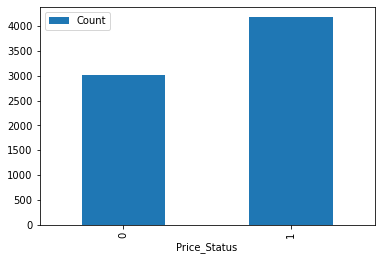

In [8]:
# Get a count of each class for the price status

print('Price Status for the classes are:', df.groupby('Price_Status').size())
plot_df = df[['Price_Status', 'year']]
plot_by_df = plot_df.rename(columns={"year": "Count"})
plot_by_df.groupby('Price_Status').count().plot.bar()

In [9]:
df_new1 = df.drop(['date'], axis=1)
df_new1.dtypes

year                         int64
county                      object
median_listing_price         int64
active_listing_count         int64
median_days_on_market        int64
new_listing_count            int64
price_increased_count        int64
price_reduced_count          int64
median_square_feet           int64
average_listing_price        int64
total_listing_count          int64
violent_crime_rate         float64
30_year_fixed_rate         float64
number_of_schools          float64
median_listing_price_mm    float64
number_of_parks            float64
Price_Status                 int32
dtype: object

In [10]:
df_new1["year"].unique()

array([2022, 2021, 2020, 2019, 2018, 2017, 2016], dtype=int64)

In [11]:
filter_df = df_new1[df_new1['year'] <2019]
#filter_df["Year"].unique()

In [12]:
len(filter_df)

3000

In [13]:

columns = [
      "county", "year",
    "active_listing_count", "median_days_on_market", "new_listing_count",
    "price_increased_count", "price_reduced_count", "median_square_feet",
    "total_listing_count", "violent_crime_rate","30_year_fixed_rate", 'number_of_schools',
     'number_of_parks',"Price_Status"]

target = ["Price_Status"]

In [14]:
# Load the data

df_data = filter_df.loc[:, columns].copy()
df_data = df_data.dropna()

df_data.reset_index(inplace=True, drop=True)

df_data.head()
len(df_data)

2610

Price Status for the classes are: Price_Status
0    1162
1    1448
dtype: int64


<AxesSubplot:xlabel='Price_Status'>

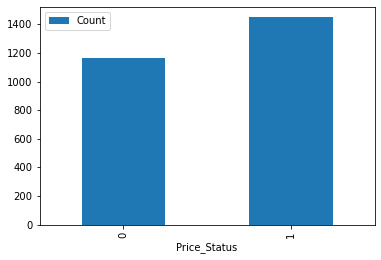

In [15]:
# Get a count of each class for the price status

print('Price Status for the classes are:', df_data.groupby('Price_Status').size())
plot_df = df_data[['Price_Status', 'year']]
plot_by_df = plot_df.rename(columns={"year": "Count"})
plot_by_df.groupby('Price_Status').count().plot.bar()

Split the Data into Training and Testing

In [16]:
# Create our features
X = df_data.drop('Price_Status', axis=1)

X = pd.get_dummies(X)

# Create our target
y = df_data.loc[:, target].copy()



In [17]:
# Check the balance of our target values
y.value_counts()

Price_Status
1               1448
0               1162
dtype: int64

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1) 
                                                 
X_test.shape


(653, 104)

In [19]:
#preprocess data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)


 Random Forest Classifier

In [20]:
# Resample the training data with the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,  max_depth=None, random_state=1) 
rf_model = rf_model.fit(X_train_scale, y_train)
Counter(y_train['Price_Status'])

Counter({0: 864, 1: 1093})

In [21]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = rf_model.predict(X_test_scale)
confusion_matrix(y_test, y_pred)


array([[124, 174],
       [134, 221]], dtype=int64)

In [22]:
# Calculated the balanced accuracy score
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)



0.5283307810107197

In [23]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.42      0.45       298
           1       0.56      0.62      0.59       355

    accuracy                           0.53       653
   macro avg       0.52      0.52      0.52       653
weighted avg       0.52      0.53      0.52       653



In [24]:
# List the features sorted in descending order by feature importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)





[(0.10477408987617778, '30_year_fixed_rate'),
 (0.10429246930588651, 'median_square_feet'),
 (0.10355818475472088, 'total_listing_count'),
 (0.10060395882558669, 'median_days_on_market'),
 (0.09927807576120727, 'active_listing_count'),
 (0.08847965714275093, 'price_reduced_count'),
 (0.08612831123734033, 'new_listing_count'),
 (0.05425895947732042, 'violent_crime_rate'),
 (0.040211090184494695, 'number_of_schools'),
 (0.03848258939288495, 'price_increased_count'),
 (0.03703107376989028, 'number_of_parks'),
 (0.024947116619401917, 'year'),
 (0.0029745695059661638, 'county_Swain'),
 (0.002832032187551361, 'county_Rutherford'),
 (0.00255110815564823, 'county_Orange'),
 (0.002293931226960004, 'county_Duplin'),
 (0.0020604024689487178, 'county_Surry'),
 (0.0020256287270832975, 'county_Stanly'),
 (0.0020126580099029917, 'county_Columbus'),
 (0.0019098926549700442, 'county_Hoke'),
 (0.0018887591715193934, 'county_Yadkin'),
 (0.0018275649568506192, 'county_Clay'),
 (0.0017322560594565013, 'cou

# Hypertune features

In [25]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [26]:
from sklearn.model_selection import RandomizedSearchCV

# Create the random grid search to use to find the best hyperparameters
random_grid = {'n_estimators': [100,200,300,400],
               'max_features': ['auto','sqrt', 'log2', None],
               'max_depth': [2,3,4,5,6, None],
                'criterion':['gini','entropy','log_loss']}

rf = RandomForestClassifier()
# using 3 fold of cross validation, radom search parameters with 100 different 
# combinations. Use all avaiable cores.

rf_search = RandomizedSearchCV(rf, random_grid,
               n_iter = 100, cv =3, verbose = 2, random_state = 1)

# fit to model

rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END criterion=log_loss, max_depth=6, max_features=log2, n_estimators=100; total time=   0.5s
[CV] END criterion=log_loss, max_depth=6, max_features=log2, n_estimators=100; total time=   0.2s
[CV] END criterion=log_loss, max_depth=6, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, n_estimators=300; total time=   0.8s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, n_estimators=300; total time=   0.8s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, n_estimators=300; total time=   0.8s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200; total time=   1.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200; total time=   1.2s
[CV] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200; total time=   1.3s
[CV] END criterion=gini, max_depth=None, max_feat

[CV] END criterion=entropy, max_depth=4, max_features=None, n_estimators=300; total time=   2.1s
[CV] END criterion=entropy, max_depth=4, max_features=None, n_estimators=300; total time=   2.2s
[CV] END criterion=entropy, max_depth=4, max_features=None, n_estimators=300; total time=   2.1s
[CV] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=200; total time=   0.4s
[CV] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=200; total time=   0.4s
[CV] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=200; total time=   0.4s
[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=200; total time=   0.4s
[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=200; total time=   0.4s
[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=200; total time=   0.4s
[CV] END criterion=gini, max_depth=6, max_features=log2, n_estimators=200; total time=   0.4s
[CV] END criterion=gini, max_dept

[CV] END criterion=log_loss, max_depth=None, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=log_loss, max_depth=None, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=4, max_features=log2, n_estimators=300; total time=   0.6s
[CV] END criterion=gini, max_depth=4, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=4, max_features=log2, n_estimators=300; total time=   0.6s
[CV] END criterion=log_loss, max_depth=4, max_features=log2, n_estimators=100; total time=   0.2s
[CV] END criterion=log_loss, max_depth=4, max_features=log2, n_estimators=100; total time=   0.2s
[CV] END criterion=log_loss, max_depth=4, max_features=log2, n_estimators=100; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, n_estimators=200; total time=   1.0s
[CV] END criterion=ent

[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=400; total time=   1.1s
[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=400; total time=   1.1s
[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=400; total time=   1.1s
[CV] END criterion=gini, max_depth=6, max_features=None, n_estimators=400; total time=   3.0s
[CV] END criterion=gini, max_depth=6, max_features=None, n_estimators=400; total time=   3.6s
[CV] END criterion=gini, max_depth=6, max_features=None, n_estimators=400; total time=   3.4s
[CV] END criterion=log_loss, max_depth=None, max_features=auto, n_estimators=100; total time=   0.5s
[CV] END criterion=log_loss, max_depth=None, max_features=auto, n_estimators=100; total time=   0.5s
[CV] END criterion=log_loss, max_depth=None, max_features=auto, n_estimators=100; total time=   0.5s
[CV] END criterion=log_

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 3, 4, 5, 6, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=1, verbose=2)

In [27]:
print(rf_search.best_params_)
print(rf_search.best_score_)

{'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini'}
0.5906927911761667


## Test RandomForestClassifier with best parameters

In [28]:

rf_model1 = RandomForestClassifier(n_estimators=100, max_depth=6, criterion='log_loss', random_state=1) 
rf_model1 =rf_model1.fit(X_train_scale, y_train)
y_pred1 = rf_model1.predict(X_test_scale)
accuracy_score( y_test, y_pred1)

confusion_matrix(y_test, y_pred1)

array([[ 50, 248],
       [ 32, 323]], dtype=int64)

In [29]:
# Calculated the balanced accuracy score
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred1)

0.5712098009188361

In [30]:
# Print classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.61      0.17      0.26       298
           1       0.57      0.91      0.70       355

    accuracy                           0.57       653
   macro avg       0.59      0.54      0.48       653
weighted avg       0.59      0.57      0.50       653



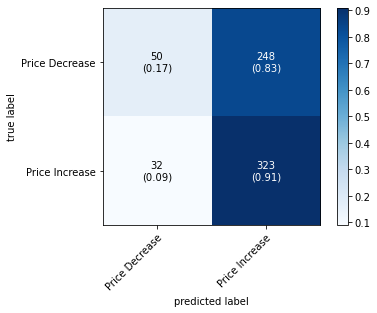

In [32]:
# Imports
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

 #Confusion Matrix
cm = np.array([[ 50, 248],
       [ 32, 323]])


classes = ['Price Decrease', 'Price Increase']


figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)

plt.show()